## 머신러닝 응용

## 03-04. 앙상블 모델 - Bagging

Bootstrap aggregating  
-> 배깅은 부트스트랩을 통해 재표본을 생성하고, 여러개의 독립적인 모델을 학습시켜 예측 결과를 결합하는 앙상블 학습 방법  

Bootstrap  
-> 통계학에서 사용되는 배표본추출방법, 랜덤하게 샘플을 선택하고 선택된 샘플로 구성된 재표본을 생성하는 과정  

Bagging  
-> 전체의 Data set을 가지고 부트스트랩 방식으로 샘플링하여 여러개의 train set 생성 -> 각 train set으로 모델 학습후 조합(평균, 최빈값 등)  

OOB(Out Of Bag)  
-> 부트스트랩 샘플에 포함되지 않고 남는 데이터 샘플, 즉 이를 기반으로 모델 성능 평가 가능  





### 0. 데이터 준비하기
- **데이터 설명**<br>
타이타닉 데이터셋은 1912년에 발생한 타이타닉호의 침몰 사고와 관련된 정보를 담고 있는 데이터셋입니다. 이 데이터셋은 Kaggle에서 제공하며 기계 학습과 데이터 분석을 위해 널리 사용되는 예제 데이터셋 중 하나로, 생존자 예측과 관련된 문제에 대한 연구 및 분석을 수행하는 데 자주 활용됩니다. <br><br>
이번 실습에서는 해당 데이터셋의 전처리 작업(결측치 처리, 가변수화, 정규화 등)을 완료한 데이터 파일('titanic_preprocessing.csv')을 활용할 예정이며, 각 컬럼은 다음과 같은 내용을 포함하고 있습니다. 

| 컬럼명         | 설명                                      |
|----------------|--------------------------------------------|
| Survived       | 생존 여부 (1: 생존, 0: 사망)               |
| Age            | 나이                                       |
| SibSp          | 함께 탑승한 형제자매 또는 배우자의 수       |
| Parch          | 함께 탑승한 부모 또는 자녀의 수             |
| Fare           | 운임 요금                                  |
| Title_Mr       | Mr. 호칭을 갖는 탑승객 여부 (1: 해당, 0: 해당X) |
| Title_Mrs      | Mrs. 호칭을 갖는 탑승객 여부 (1: 해당, 0: 해당X)|
| Title_Others   | Mr., Mrs. Miss 이외의 호칭을 갖는 탑승객 여부  |
| Pclass_2       | 2등석 여부 (1: 해당, 0: 해당X)              |
| Pclass_3       | 3등석 여부 (1: 해당, 0: 해당X)              |
| Sex_male       | 성별이 남성인지 여부 (1: 남성, 0: 여성)     |
| Embarked_Q     | 탑승지가 Queenstown인지 여부 (1: 해당, 0: 해당X)|
| Embarked_S     | 탑승지가 Southampton인지 여부 (1: 해당, 0: 해당X)|


#### 1️⃣ 데이터 불러오기

In [1]:
# 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 읽어오기
df = pd.read_csv("./data/titanic_preprocessing.csv")

In [3]:
# 샘플 데이터 확인하기
df.head()

,Survived,Age,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Others,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.0,0.271174,0.125,0.0,0.014151,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.0,0.472229,0.125,0.0,0.139136,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.321438,0.000,0.0,0.015469,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.434531,0.125,0.0,0.103644,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.434531,0.000,0.0,0.015713,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


#### 2️⃣ 데이터 분리하기

In [5]:
# Feature는 x, Target은 y 로 저장합니다.
x = df.drop(columns=['Survived'])
y = df['Survived']

In [6]:
# sklearn 패키키 증 train_test_split 함수 불러오기
from sklearn.model_selection import train_test_split

# Feature와 Target을 train, test 데이터 셋으로 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


---

### 1. RandomForest 모델

#### 1️⃣ 라이브러리 호출하기

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#### 2️⃣ 선언하기 
RandomForestClassifier 클래스 객체 생성하기<br><br>
**📌 <font color='red'>주의사항</font>**<br>
랜덤 포레스트에서의 랜덤 시드는 주로 **'random state'** 파라미터를 통해 설정됩니다. <br>이 값을 지정하지 않으면 매번 다른 결과가 나오게 되며, 동일한 값을 사용하면 항상 동일한 예측 결과를 얻을 수 있습니다.<br>
***추후 있을 모델 성능 최적화 작업 시에는 반드시 'random_state' 값을 고정하고 최적화 작업을 진행해야 합니다.***

In [8]:
# 모델 생성
model_rf = RandomForestClassifier(random_state=42)

#### 3️⃣ 학습하기
fit 메서드로 가중치 값을 추정한다.

In [9]:
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

#### 4️⃣ 예측하기
predict 메서드로 새로운 입력 데이터에 대한 출력 데이터 예측



In [10]:
y_pred = model_rf.predict(x_test)

#### 5️⃣ 평가하기

In [11]:
print("[classification_report]")
print(classification_report(y_test, y_pred))

[classification_report]
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       105
         1.0       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



#### 6️⃣ 파라미터 조정하기
> - n_estimators : 의사 결정 트리의 개수<br> 
> 일반적으로 더 많은 트리를 사용할수록 모델의 성능이 향상되지만, 학습 속도는 느려집니다. 이 값을 적절히 조정하여 과적합과 학습 시간 사이의 균형을 맞추어야 합니다.<br>
> - max_depth : 의사 결정 트리의 최대 깊이 <br>
> 트리의 깊이가 깊어질수록 모델의 복잡도가 증가하고 과적합의 위험이 커집니다. 이 값을 제한함으로써 모델의 일반화 성능을 향상시킬 수 있습니다. <br>
> - min_samples_split: 내부 노드를 분할하기 위해 필요한 최소 샘플 수<br> 
> 이 값보다 작은 수의 샘플이 있는 노드만 분할이 가능합니다. 작은 값은 모델이 더 복잡해지고 과적합의 위험이 커질 수 있지만, 큰 값은 모델이 덜 유연해지고 과소적합의 위험이 커질 수 있습니다.<br>
> - min_samples_leaf: 리프 노드가 되기 위해 필요한 최소 샘플 수. <br>
> 이 값보다 작은 수의 샘플이 있는 리프 노드는 분할되지 않습니다. 작은 값은 모델이 더 자세하게 학습되고 과적합의 위험이 커질 수 있지만, 큰 값은 모델이 덜 자세하게 학습되고 과소적합의 위험이 커질 수 있습니다.<br>
> - max_features: 각 의사 결정 트리가 분할에 사용할 특성의 최대 개수<br>
> 작은 값은 모델이 더 간단해지고 과소적합의 위험이 커질 수 있지만, 큰 값은 모델이 더 복잡해지고 과적합의 위험이 커질 수 있습니다.<br>
> - oob_score: oob_score 파라미터를 True로 설정하면, 랜덤 포레스트 모델이 학습 과정에서 사용하지 않는 oob 샘플을 자동으로 식별합니다. 그리고 이러한 oob 샘플을 통해 모델의 성능을 평가합니다.

In [13]:
# 모델 선언
model_rf2 = RandomForestClassifier(n_estimators=300,  random_state=42, oob_score=True)

# 모델 학습
model_rf2.fit(x_train, y_train)

# 모델 예측
y_pred = model_rf2.predict(x_test)

# 모델 평가 
print("[classification_report]")
print(classification_report(y_test, y_pred))

[classification_report]
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       105
         1.0       0.82      0.81      0.82        74

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [14]:
# oob 점수 확인
oob_score = model_rf2.oob_score_
print("OOB Score:", oob_score)

OOB Score: 0.8089887640449438


---

### 2. Extra Tree 모델

#### 1️⃣ 라이브러리 호출하기

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

#### 2️⃣ 선언하기
ExtraTreesClassifier 클래스 객체 생성하기<br>

**📌 <font color='red'>주의사항</font>**<br>
트리의 노드를 무작위로 분할하는 특징 때문에, 보통 Random Forest보다 결정트리 수('n_estimators')를 크게 하는 것이 좋습니다. 

In [16]:
model_et = ExtraTreesClassifier(n_estimators=1000, random_state=42)

#### 3️⃣ 학습하기

In [17]:
model_et.fit(x_train, y_train)

ExtraTreesClassifier(n_estimators=1000, random_state=42)

#### 4️⃣ 예측하기

In [18]:
y_pred = model_et.predict(x_test)

#### 5️⃣ 평가하기

In [19]:
print("[classification_report]")
print(classification_report(y_test, y_pred))

[classification_report]
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83       105
         1.0       0.75      0.81      0.78        74

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.81      0.81      0.81       179



---

### 3. Feature Importance

#### 1️⃣ 특성 중요도 추출하여 데이터 프레임 만들기

In [20]:
# Random Forest 모델 특성 중요도 추출
importances = model_rf.feature_importances_

In [21]:
importances

array([0.22000575, 0.05211409, 0.03581687, 0.25648177, 0.12050399,
       0.03413297, 0.00982117, 0.01806091, 0.06194318, 0.15496484,
       0.0104982 , 0.02565627])

In [22]:
# 특성 중요도를 데이터프레임으로 변환
feature_importances = pd.DataFrame({'Feature': x.columns, 
                                    'Importance': importances})

In [23]:
feature_importances

,Feature,Importance
0,Age,0.220006
1,SibSp,0.052114
2,Parch,0.035817
3,Fare,0.256482
4,Title_Mr,0.120504
5,Title_Mrs,0.034133
6,Title_Others,0.009821
7,Pclass_2,0.018061
8,Pclass_3,0.061943
9,Sex_male,0.154965


In [24]:
# 특성 중요도를 내림차순으로 정렬
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances

,Feature,Importance
3,Fare,0.256482
0,Age,0.220006
9,Sex_male,0.154965
4,Title_Mr,0.120504
8,Pclass_3,0.061943
1,SibSp,0.052114
2,Parch,0.035817
5,Title_Mrs,0.034133
11,Embarked_S,0.025656
7,Pclass_2,0.018061


#### 2️⃣ 특성 중요도 차트로 표현하기

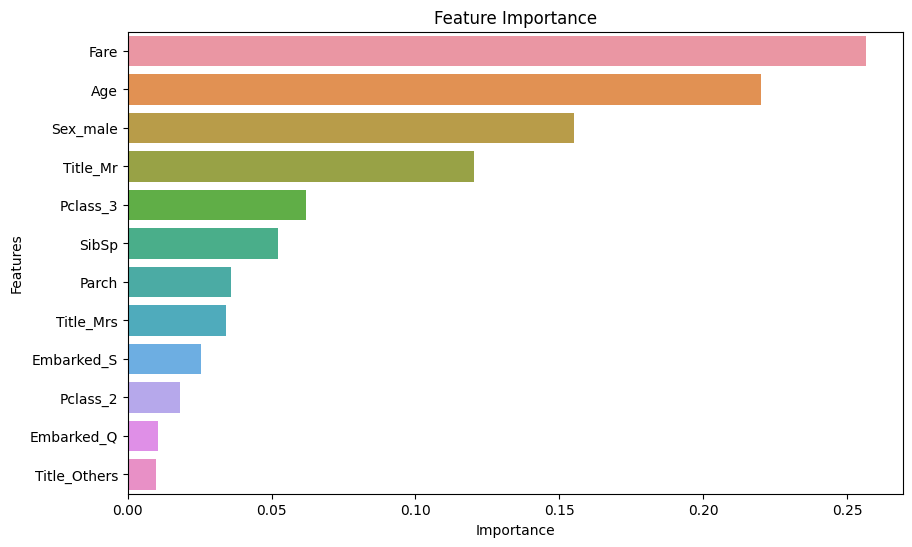

In [25]:
# 차트 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

#### 3️⃣ 특성 중요도가 낮은 Feature 제거 후 재 모델링
가 변수화 Feature('Title', 'Pclass', 'Embarked')를 제외한 변수 중 중요도가 낮은 'Parch': 부모와 자녀 수 제거 후 재 모델링

In [26]:
# Feature는 x, Target은 y 로 저장합니다.
x = df.drop(columns=['Survived', 'Parch'])
y = df['Survived']

from sklearn.model_selection import train_test_split

# Feature와 Target을 train, test 데이터 셋으로 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [27]:
# 모델 생성
model_rf3 = RandomForestClassifier(random_state=42, oob_score=True)

# 모델 학습
model_rf3.fit(x_train, y_train)

# 모델 예측 
y_pred = model_rf3.predict(x_test)

# 모델 평가
print("[classification_report]")
print(classification_report(y_test, y_pred))

[classification_report]
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87       105
         1.0       0.81      0.82      0.82        74

    accuracy                           0.85       179
   macro avg       0.84      0.85      0.84       179
weighted avg       0.85      0.85      0.85       179



---